In [43]:
import pandas as pd

In [44]:
# Load dataset
df = pd.read_csv('reduced_data.csv')

In [45]:
# # Reduce the DataFrame to 200 rows selected at random
# reduced_df = df.sample(n=200, random_state=42)

# # Save the reduced DataFrame to a CSV file in the same directory
# reduced_df.to_csv('reduced_data.csv', index=False)


In [46]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

# Sample features and labels
num_nodes = 200
num_node_features = 6  # For BMI, Sex, Age, PhysHlth, MentHlth, GenHlth
num_classes = 2  # Diabetic and HeartDisease

# Generate dummy features and labels
torch.manual_seed(42)  # For reproducibility
x = torch.randn(num_nodes, num_node_features)
y = torch.randint(0, 2, (num_nodes, num_classes))

# Define edges (dummy example: each node is connected to next and previous node in a loop)
edge_index = torch.tensor([[i, i+1] for i in range(num_nodes-1)] + [[num_nodes-1, 0]], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index[:, [1, 0]]], dim=0).t()

# Create a PyG data object
data = Data(x=x, edge_index=edge_index, y=y)


In [47]:
# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=4, concat=True)
        self.conv2 = GATConv(hidden_channels * 4, num_classes, heads=1, concat=False)

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        # Second GAT layer
        x = self.conv2(x, edge_index)
        return x

In [48]:
# Initialize model, optimizer, and loss function
model = GAT(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y.float())
    loss.backward()
    optimizer.step()
    return loss.item()


In [52]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        # Convert logits to probabilities using sigmoid
        y_pred_prob = torch.sigmoid(out)
        # Convert probabilities to binary predictions
        y_pred = (y_pred_prob > 0.5).type(torch.int).numpy()
        y_true = data.y.numpy()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        auc_roc = roc_auc_score(y_true, y_pred_prob.numpy(), average='macro', multi_class='ovr')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_roc': auc_roc
        }

# Training the model
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        metrics = evaluate()
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Metrics: Acc: {metrics['accuracy']:.4f}, "
              f"Prec: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
              f"F1: {metrics['f1']:.4f}, AUC-ROC: {metrics['auc_roc']:.4f}")

# Final evaluation
final_metrics = evaluate()
print(f'Final Evaluation Metrics: {final_metrics}')


Epoch: 0, Loss: 0.6086, Metrics: Acc: 0.4700, Prec: 0.6898, Recall: 0.7053, F1: 0.6970, AUC-ROC: 0.7796
Epoch: 10, Loss: 0.5806, Metrics: Acc: 0.4650, Prec: 0.6825, Recall: 0.7060, F1: 0.6939, AUC-ROC: 0.7804
Epoch: 20, Loss: 0.5848, Metrics: Acc: 0.4650, Prec: 0.6838, Recall: 0.7107, F1: 0.6968, AUC-ROC: 0.7808
Epoch: 30, Loss: 0.5827, Metrics: Acc: 0.4600, Prec: 0.6823, Recall: 0.6959, F1: 0.6890, AUC-ROC: 0.7829
Epoch: 40, Loss: 0.5951, Metrics: Acc: 0.4650, Prec: 0.6928, Recall: 0.7060, F1: 0.6992, AUC-ROC: 0.7815
Epoch: 50, Loss: 0.6114, Metrics: Acc: 0.4650, Prec: 0.6952, Recall: 0.7013, F1: 0.6981, AUC-ROC: 0.7811
Epoch: 60, Loss: 0.5935, Metrics: Acc: 0.4650, Prec: 0.6842, Recall: 0.7107, F1: 0.6970, AUC-ROC: 0.7836
Epoch: 70, Loss: 0.5906, Metrics: Acc: 0.4700, Prec: 0.6880, Recall: 0.7147, F1: 0.7008, AUC-ROC: 0.7864
Epoch: 80, Loss: 0.5914, Metrics: Acc: 0.4800, Prec: 0.6928, Recall: 0.7403, F1: 0.7154, AUC-ROC: 0.7856
Epoch: 90, Loss: 0.5852, Metrics: Acc: 0.4750, Prec: 0.6

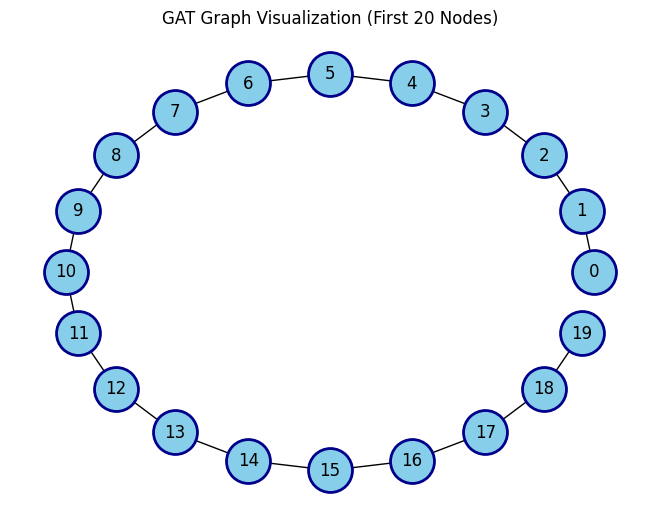

In [53]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    edges = edge_index.t().numpy()
    G.add_edges_from(edges)

    # Since we want to visualize only the first 20 nodes
    sub_G = G.subgraph(range(20))

    # Generate layout for visualization
    pos = nx.circular_layout(sub_G)  # Circular layout for the subgraph

    # Options for node sizes, colors, and labels for clarity
    node_color = 'skyblue'
    node_size = 1000  # Adjusted size for better visibility
    font_size = 12    # Adjusted font size for clarity

    # Draw the nodes and edges with options for better visualization
    nx.draw(sub_G, pos, node_color=node_color, node_size=node_size, with_labels=True, font_size=font_size, edge_color='k')

    # Add a visual distinction for node borders
    nx.draw_networkx_nodes(sub_G, pos, node_color=node_color, node_size=node_size, edgecolors='darkblue', linewidths=2)

    plt.title("GAT Graph Visualization (First 20 Nodes)")
    plt.show()

# Edge index setup
num_nodes = 200  # total number of nodes
# Connect each node to the next and loop back from the last to the first
edge_index = torch.tensor([[i, (i+1) % num_nodes] for i in range(num_nodes)], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index[:, [1, 0]]], dim=0).t()

# Call the function to plot the graph for the first 20 nodes
plot_graph(edge_index, num_nodes)


In [54]:
# New patient data
new_patient_features = torch.tensor([[25, 1, 55, 0, 10, 5]], dtype=torch.float)
new_patient_edge_index = torch.tensor([[], []], dtype=torch.long)

# Prediction
with torch.no_grad():
    output = model(new_patient_features, new_patient_edge_index)
    predicted_probabilities = torch.sigmoid(output)
    predicted_classes = (predicted_probabilities > 0.5).int()

# The first class (condition) corresponds to diabetes.
# The second class (condition) corresponds to heart disease.
print("Predicted probabilities:", predicted_probabilities.numpy())
print("Predicted classes (0: No, 1: Yes):", predicted_classes.numpy())

Predicted probabilities: [[0.99515873 1.        ]]
Predicted classes (0: No, 1: Yes): [[1 1]]
